# Result Analysis: Datamodels by Question

The goal here is to analyse and compare the results of the datamodels with the goal the visualize the relation of the most influent samples when comparing with the random and same document.  
We will compare the performance with: Baseline, FAISS and Datamodels

In [1]:
import polars as pl
import torch
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data Results

In [2]:
### Train samples
train_sets = []
for i in range(5):
    train_sets.append(pl.read_csv(f"question_{i}_datamodels/train_set.csv").with_columns(pl.lit(f"question_{i}").alias("question_id")))
train = pl.concat(train_sets)

In [3]:
### Load weights
weights_set = []
for i in range(5):
    weights = torch.load(f"question_{i}_datamodels/models/regression_question_{i}/weights.pt").to("cpu")
    weights_set.append(weights)


/tmp/ipykernel_309684/2209797913.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"question_{i}_datamodels/models/regression_question_{i}/weights.pt

In [4]:
## Evaluations
evaluations = []
for i in range(5):
    evaluation = pl.read_ipc(f"question_{i}_datamodels/evaluations/evaluation_question_{i}.feather").with_columns(pl.lit(f"question_{i}").alias("question_id"))
    evaluations.append(evaluation)

evaluations = pl.concat(evaluations)
evaluations.head()

mse,test_idx,question_id
f64,i64,str
0.0001,0,"""question_0"""
0.0001,0,"""question_1"""
0.0122,0,"""question_2"""
0.0003,0,"""question_3"""
0.0003,0,"""question_4"""


In [5]:
## Training collections
collections_training_set = []
for i in range(5):
    collection_i = pl.read_ipc(f"question_{i}_datamodels/collections/train/collection_question_{i}.feather").with_columns(pl.lit(f"question_{i}").alias("question_id"))
    collections_training_set.append(collection_i)


## Test collections
collections_test_set = []
for i in range(5):
    collection_i = pl.read_ipc(f"question_{i}_datamodels/collections/test/collection_question_{i}.feather").with_columns(pl.lit(f"question_{i}").alias("question_id"))
    collections_test_set.append(collection_i)



In [6]:

## add weights to sample training
list_weights = []
for set in weights_set:
    for _w in set[0]:
        list_weights.append(float(_w.item()))


train = train.with_columns(
    pl.Series("weights", list_weights),
    pl.when(pl.col("idx_right").is_not_null())
        .then(True)
        .otherwise(False)
        .alias("is_from_same_page")

)

## Target Questions

In [7]:
questions = []
for i in range(5):
    questions.append(pl.read_csv(f"question_{i}_datamodels/test_set.csv"))

questions = pl.concat(questions)
questions.select("question").to_numpy()


array([['when did the who perform at the super bowl'],
       ['why was there so much interest in cuba both before and after the civil war'],
       ['who developed the first periodic table with 8 columns'],
       ['the organization of the formal elements in an art work'],
       ['where did the french king live before versailles']], dtype=object)

## Group Proportion by Question

<Axes: xlabel='question_id', ylabel='count'>

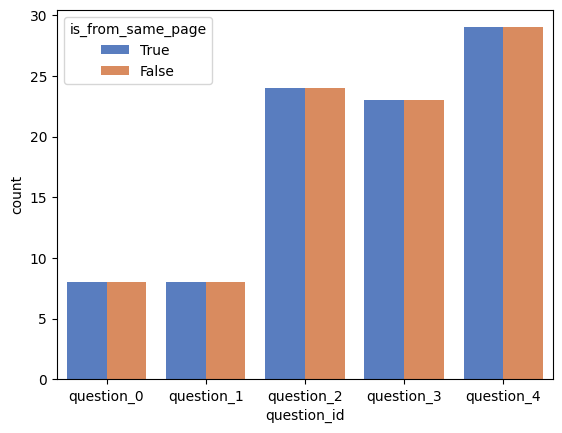

In [8]:
proportion = (
    train
    .with_columns(
        pl.when(pl.col("idx_right").is_not_null())
        .then(True)
        .otherwise(False)
        .alias("is_from_same_page")
    )
    .group_by("question_id", "is_from_same_page")
    .agg(pl.col("idx").count().alias("count"))
    .sort("question_id", "is_from_same_page")
)



sns.barplot(
    data=proportion,
    x="question_id",
    y="count",
    hue="is_from_same_page",
    hue_order=[True, False],
    palette="muted"
)

## Group Wieghts Analysis by Question

The goal here is to analyse the behavior of the curve of influece for questions
- How it looks like?

- Which of the three groups of training showed the highest evaluation metrics?

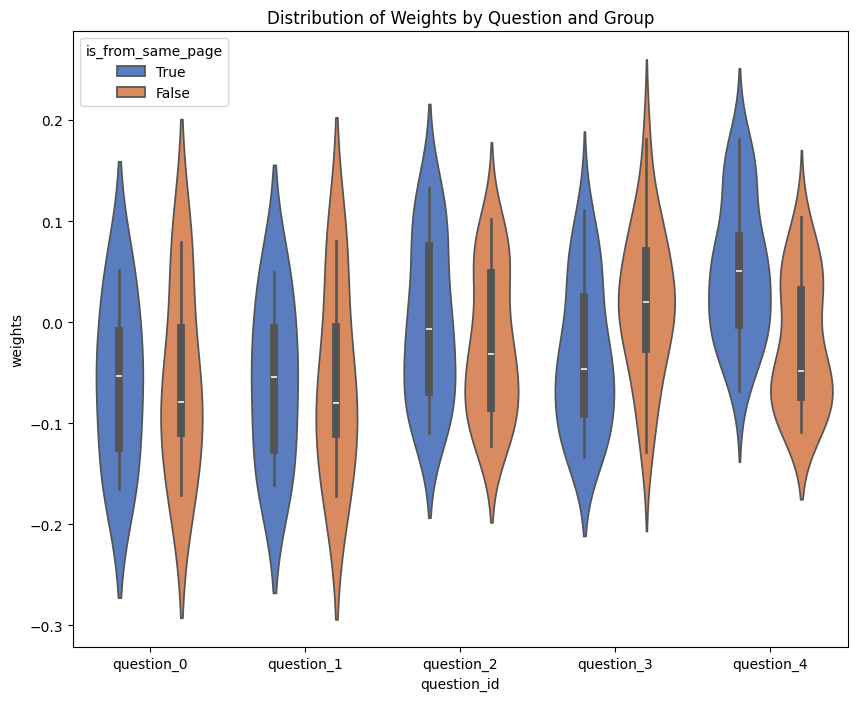

In [9]:



distribution = (
    train
    .select("question_id", "weights", "is_from_same_page")
)
fig, ax = plt.subplots(figsize=(10, 8))

sns.violinplot(
    data=distribution,
    x="question_id",
    y="weights",
    hue="is_from_same_page",
    hue_order=[True, False],
    palette="muted",
    ax=ax
    )

plt.title("Distribution of Weights by Question and Group")
plt.show()

In [10]:
## Percentage of same group in top 8
top8_same_page = (
    train
    .sort(["question_id", "weights"], descending=[False, True])
    .group_by("question_id", maintain_order=True)
    .head(10)
    .filter(pl.col("is_from_same_page") == True)
    .group_by("question_id")
    .agg(pl.col("idx").count().alias("count"))
    .sort("question_id")
)

top8_same_page

question_id,count
str,u32
"""question_0""",5
"""question_1""",5
"""question_2""",7
"""question_3""",3
"""question_4""",9


## Comparison - Target value distribution by sampling group (Random, Mixed, Same Page)

In [11]:
group_tag = []

group_collections = [pl.DataFrame(c).drop("input") for c in collections_training_set]
for i in range(len(group_collections)):
    group_collections[i] = (
        group_collections[i]
        .with_columns((pl.col("collection_idx") // 45).alias("segment"))
        .with_columns(
            pl.when(pl.col("segment") == 0)
            .then(pl.lit("same_group"))
            .when(pl.col("segment") == 1)
            .then(pl.lit("random"))
            .otherwise(pl.lit("mixed"))
            .alias("groups")
        )
        .drop("segment", "collection_idx")
    )
train_collections = pl.concat(group_collections)


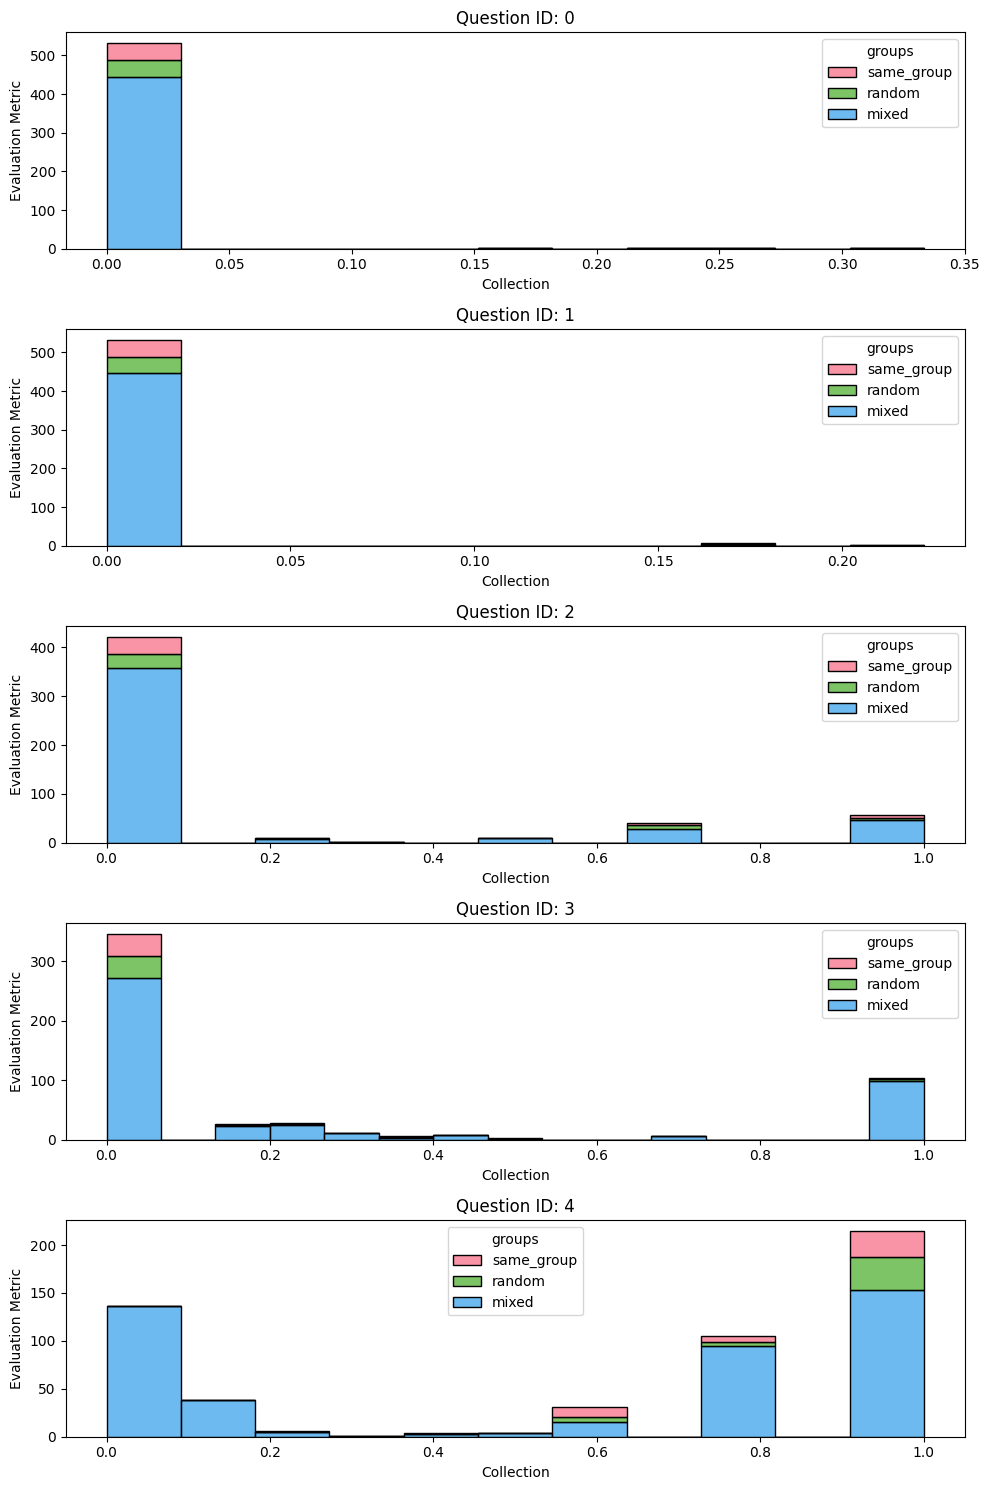

In [12]:

fig, axes = plt.subplots(5, figsize=(10, 15))

# Create a bar plot for each question_id
for i in range(5):

    df = train_collections.filter(pl.col("question_id") == f"question_{i}")
    sns.histplot(
        data=df,
        x="evaluation",
        hue="groups",
        multiple="stack",
        palette="husl",
        ax=axes[i]
    )
   
    
    # Customize the plot
    axes[i].set_title(f'Question ID: {i}')
    axes[i].set_xlabel("Collection")
    axes[i].set_ylabel("Evaluation Metric")
    
plt.tight_layout()
plt.show()

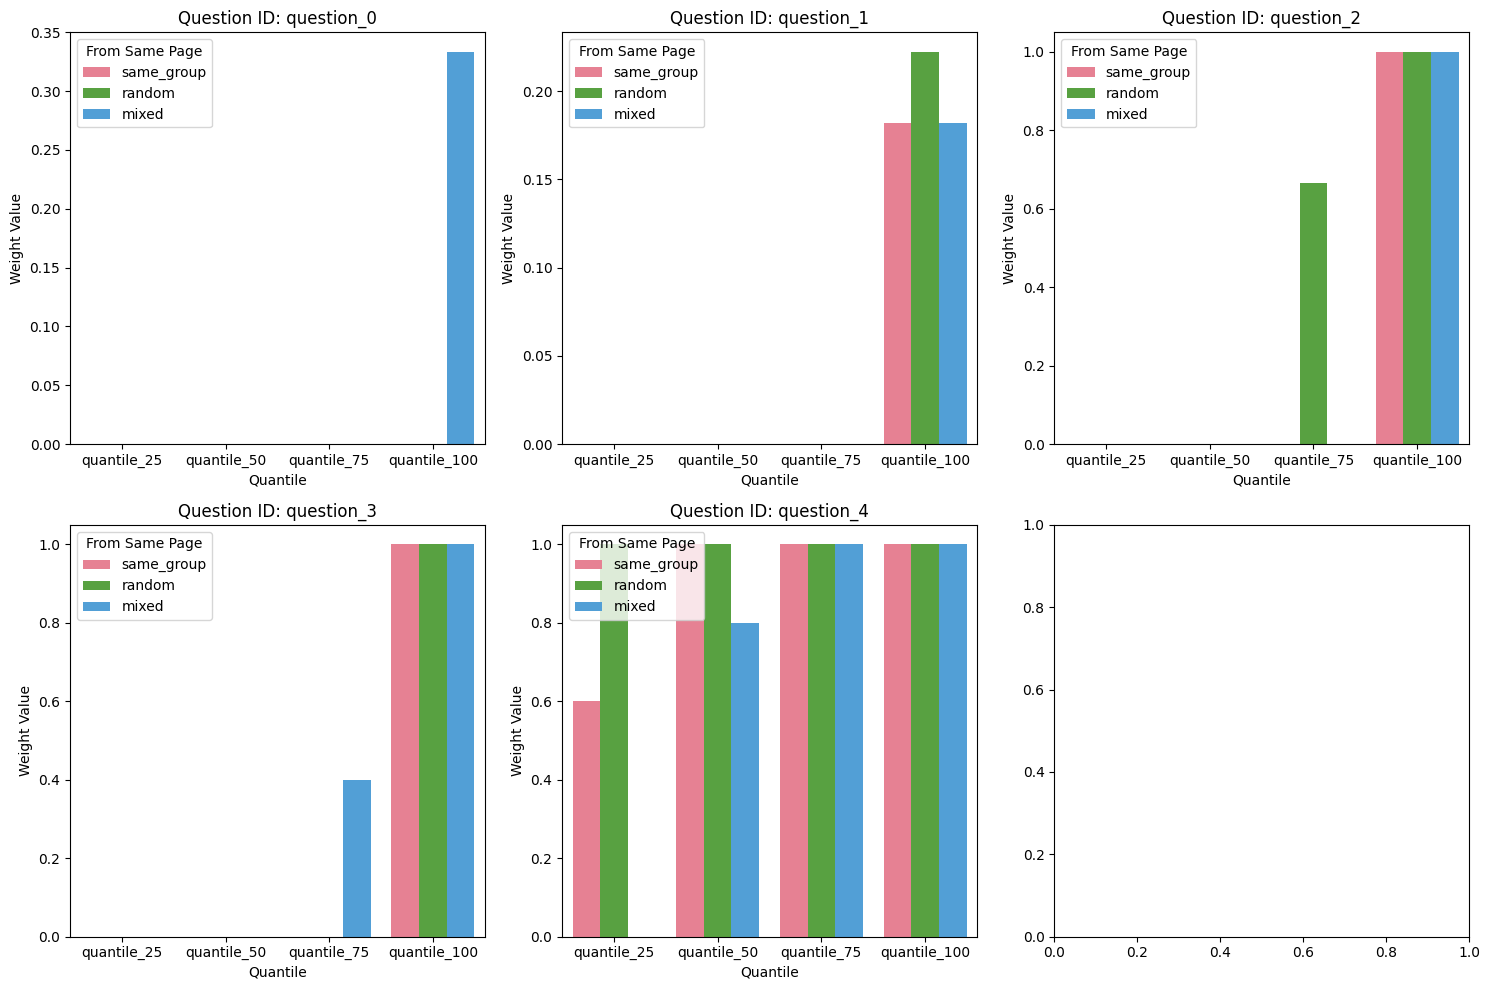

In [13]:
## QUARTILES
quarters_groups = (
    train_collections
    .select("question_id", "evaluation", "groups")
    .group_by("question_id", "groups")
    .agg(
        pl.col("evaluation").quantile(0.25).alias("quantile_25"),
        pl.col("evaluation").quantile(0.5).alias("quantile_50"),
        pl.col("evaluation").quantile(0.75).alias("quantile_75"),
        pl.col("evaluation").quantile(1).alias("quantile_100")
    )
)


quarters_pd = quarters_groups.sort('question_id').to_pandas()
question_ids = quarters_pd['question_id'].unique()

row = 0
col = 0
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(15, 10))

# Create a bar plot for each question_id
for i, question_id in enumerate(question_ids):
    # Filter data for this question_id
    data = quarters_pd[quarters_pd['question_id'] == question_id]
    
    # Melt the data to have quantiles as rows instead of columns
    melted = data.melt(id_vars=['question_id', 'groups'], 
                      value_vars=['quantile_25', 'quantile_50', 'quantile_75', 'quantile_100'],
                      var_name='quantile', value_name='value')
    
    # Create the bar plot
    sns.barplot(data=melted, x='quantile', y='value', hue='groups', ax=axes[row, col], palette="husl", hue_order=["same_group","random", "mixed"])
    
    # Customize the plot
    axes[row, col].set_title(f'Question ID: {question_id}')
    axes[row, col].set_xlabel('Quantile')
    axes[row, col].set_ylabel('Weight Value')
    axes[row, col].legend(title='From Same Page')

    if col == 2:
        row += 1
        col = 0
    
    else:
        col +=1
    
plt.tight_layout()
plt.show()